In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gudhi as gud
from gudhi.representations import Landscape

In [2]:
# DATA from https://data.mendeley.com/datasets/k4x675k5dm/2
# It is not the complete dataset
# You can take a look to the codification of data in the header of the txt file
DATA = np.loadtxt("chaos_nochaos.txt.gz")

In [3]:
DATA.shape

(2000, 3007)

In [4]:
N = 50 # Number of points used for the clasification

# The 6th column contains the main Lyapunov exponent... 
# it if is greater than 0, then the orbit is chaotic
# We consider chaotic those orbits with a sligthly larger than 0 LE
chaotic = DATA[:,6] > 0.01 

# We keep the last N points in R^3
orbits = DATA[:,-3*N:].reshape((-1,N,3))

print("Number of chaotic orbits", chaotic.sum())

Number of chaotic orbits 1000


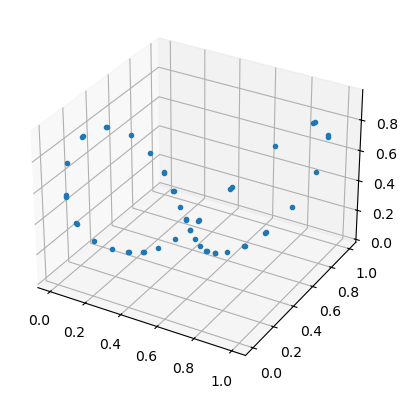

In [5]:
# Take a look to an orbit
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot( *orbits[1].transpose(), '.' ) # Yout can change the number here to see other orbits

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

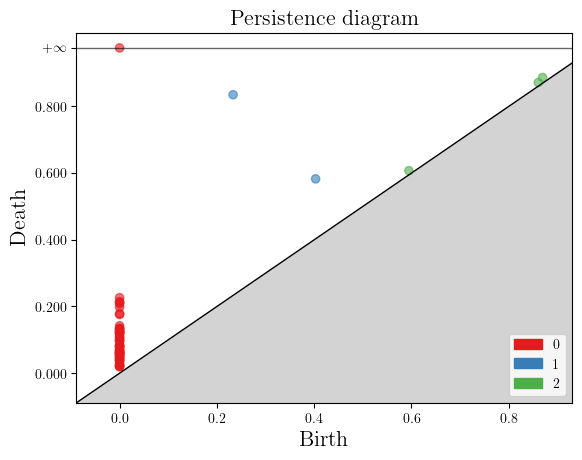

In [6]:
# Here we compute the persistence diagram for a single orbit
VR = gud.RipsComplex(points=orbits[300]) # You can change here the orbit number...
ST = VR.create_simplex_tree(max_dimension=1)
ST.collapse_edges(nb_iterations=10) # Here we reduce de complexity of the complex to improve computation times
ST.expansion(max_dimension=3)
diag = ST.persistence() # to filter min_persistence
gud.plot_persistence_diagram(diag)


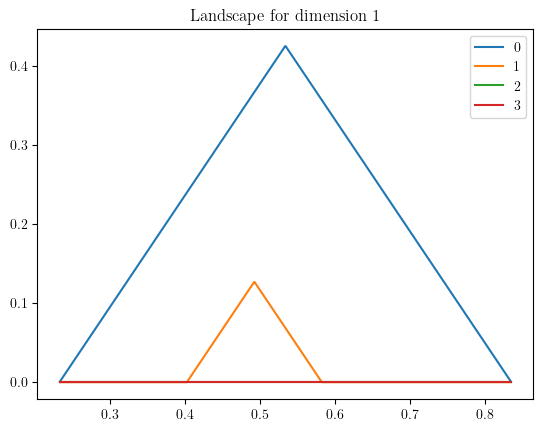

In [7]:
# The landscape for the previous orbit
resolution = 1000
DIM = 1
LS = gud.representations.Landscape(resolution=resolution)
L = LS.fit_transform([ST.persistence_intervals_in_dimension(DIM)])
for i in range(4):
    plt.plot(
        np.linspace(*LS.sample_range_fixed_, resolution), 
        L[0][resolution*i:resolution*(i+1)], label=str(i)
    )
plt.title(f"Landscape for dimension {DIM}")
plt.legend()
plt.show()


In [8]:
def orbit2landscape(orbits, resolution=100, dimension=1, up_to_depth=3):
    """
    The input of this function is a bunch of orbits and compute the landscapes of 
    all of them. You can give to it the resolution, dimension, and value of k (up_to_depth)
    of the landscape. For each orbit the output is an array of up_to_depth * resolution
    numbers, since the diferent landscapes (foer each k) are concatenated
    """
    from ipywidgets import IntProgress # For get some feedback in the notebook... in CLI use tqdm
    from IPython.display import display
    
    # compute the simplicial tree (data structure from we can get everything else)
    # There is room to improvement... compute all at once

    STs = []
    progress = IntProgress(min=0, max=len(orbits)) # instantiate the bar
    display(progress)
    for orbit in orbits:
        VR = gud.RipsComplex(points=orbit)
        ST = VR.create_simplex_tree(max_dimension=1)
        ST.collapse_edges(nb_iterations=10)
        ST.expansion(max_dimension=dimension+1)
        ST.compute_persistence(persistence_dim_max=dimension)
        STs.append(ST.persistence_intervals_in_dimension(dimension))
        progress.value += 1
        
    # Compute the landscape
    LS = gud.representations.Landscape(resolution=resolution, num_landscapes=up_to_depth)
    LS.fit(STs) 

    progress.close()
    
    return LS, STs

In [9]:
LS,STs = orbit2landscape(orbits)

IntProgress(value=0, max=2000)

In [10]:
STs = np.array(STs, dtype=object)
chaotic_landscapes = LS.transform(STs[chaotic])
nonchaotic_landscapes = LS.transform(STs[np.logical_not(chaotic)])

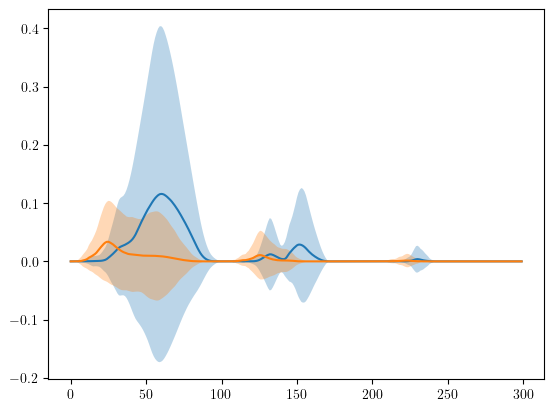

In [11]:
for x in [nonchaotic_landscapes, chaotic_landscapes]:
    m = x.mean(axis=0)
    s = x.std(axis=0)
    ci_l, ci_u = m-2*s, m+2*s
    plt.plot(m)
    plt.fill_between(np.arange(len(m)), ci_l, ci_u, alpha=.3)

#plt.plot(m)
#plt.plot(s)

In [12]:
# As you can see below, I do not have enough memory in this machine to make the 
# Bootstrap graphic... you could reduce de sample to take a look... or use a machine 
# with more memory, lik ethe laptop I used during the session.

from scipy.stats import bootstrap

for x,label in [(nonchaotic_landscapes, "Non-chaotic"), 
                (chaotic_landscapes, "Chaotic")]:
    res = bootstrap((np.transpose(x),), np.std, axis=-1, method='percentile', confidence_level=0.95)
    ci_l, ci_u = res.confidence_interval
    m = x.mean(axis=0)
    #plt.plot(m)
    plt.fill_between(np.arange(len(m)), ci_l, ci_u, alpha=.5, label=label)
plt.legend()
#plt.plot(m)
#plt.plot(s)

MemoryError: Unable to allocate 22.3 GiB for an array with shape (9999, 1000, 300) and data type float64

In [13]:
# Here I build a simple linear model for classify the orbits.
# We use 1800 orbits to build the model 
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(LS.transform(STs[:-200]), chaotic[:-200].astype(float))

LogisticRegression()

In [14]:
# Here we use the the other 200 orbits to test the model... not bad for this simple solution!
(classifier.predict(LS.transform(STs[-200:])) == chaotic[-200:]).sum() / 200

np.float64(0.855)